In [37]:
from matplotlib import pyplot as plt
import random

In [38]:
def interpolate_images(img1, img2, factor):
    # Veic pāreju starp diviem attēliem
    # Factor 0 nozīmē ka pilnībā redzams tikai img1
    # Factor 1 nozīmē ka pilnībā redzams tikai img2
    # Tiek pieņemts ka attēliem ir vienādas dimensijas - ja tā nav - pats esi vainīgs
    # Tiek arī pieņemts ka abu attēlu feature vērtības ir apgabalā [0;+1] (kas ir arī SOM svaru īpašība)
    new_image = [
        [
            [img1[i][j][0]*(1-factor) + img2[i][j][0]*factor,
             img1[i][j][1]*(1-factor) + img2[i][j][1]*factor,
             img1[i][j][2]*(1-factor) + img2[i][j][2]*factor] for j in range(len(img1[0]))
        ] for i in range(len(img1))
    ]

    return new_image

def random_image(dimension):
    new_image = [[[random.random(),random.random(),random.random()] for j in range(dimension)] for i in range(dimension)]

    return new_image

# image ir NxN masīvs, kurā katrs elements ir vektors [x1, x2, x3]
def plot_som(image, meta_this_epoch=None, meta_max_epoch=None):
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    if meta_this_epoch is not None and meta_max_epoch is not None:
        plt.title("Epoha {} no {}".format(meta_this_epoch, meta_max_epoch))

    plt.imshow(image, interpolation='gaussian')
    plt.show()

# image_list ir masīvs, kurš sastāv no iepriekš aprakstītā veida "images"
def som_animation(image_list, frames_per_epoch=30):
    previous_image = None
    for idx, img in enumerate(image_list):
        if previous_image is None:
            # Vajag uzstādīt pirmo attēlu, no kura notiks pāreja
            previous_image = img
            continue

        for i in range(frames_per_epoch):
            interp_img = interpolate_images(previous_image, img, i/frames_per_epoch)
            plot_som(interp_img, meta_this_epoch=idx, meta_max_epoch=len(image_list))
        previous_image = img

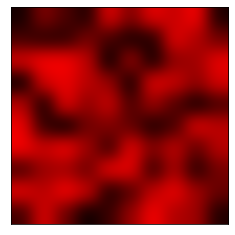

In [39]:
list_x = [random_image(10) for i in range(2)]
plot_som(list_x[0])

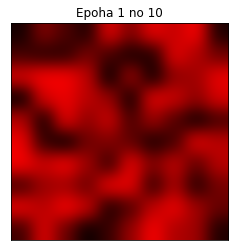

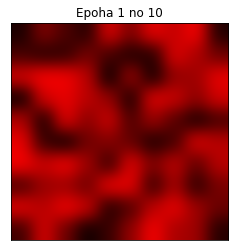

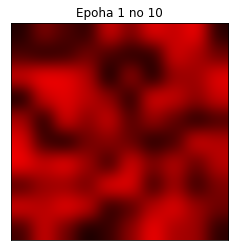

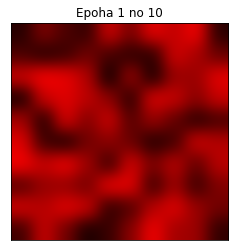

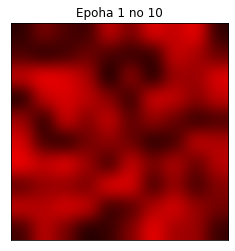

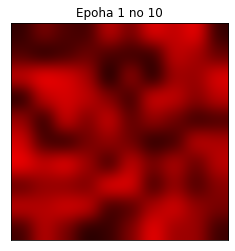

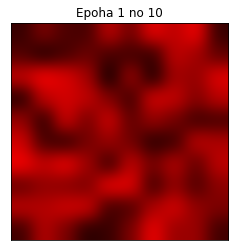

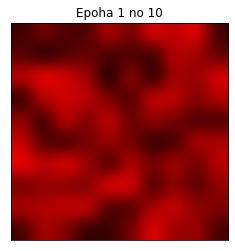

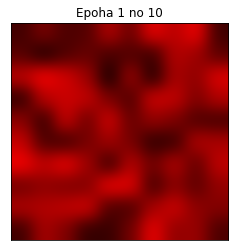

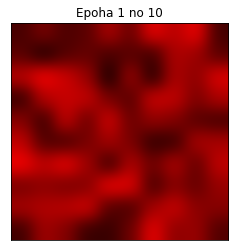

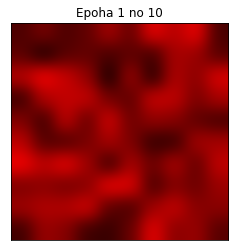

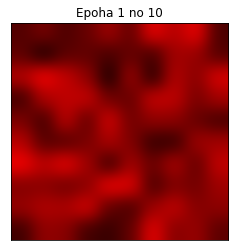

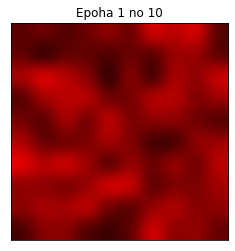

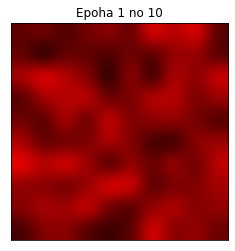

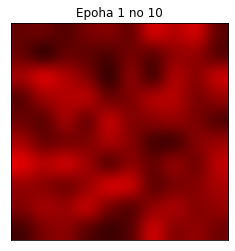

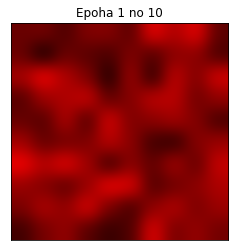

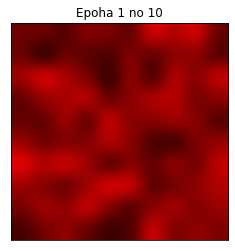

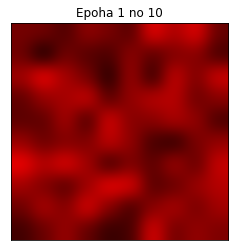

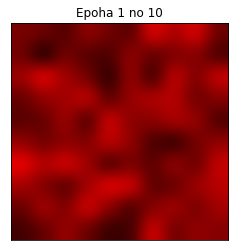

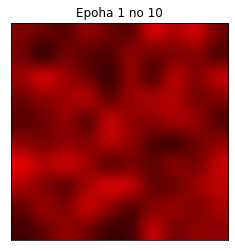

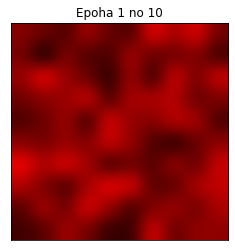

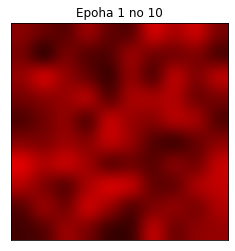

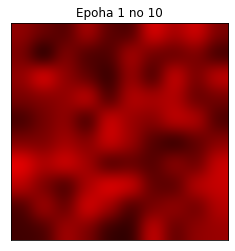

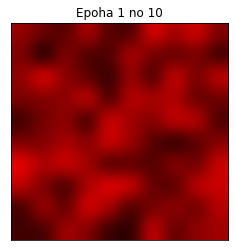

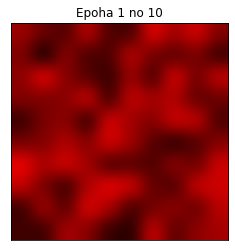

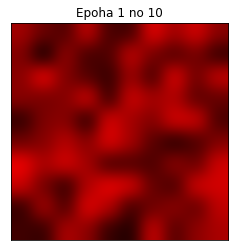

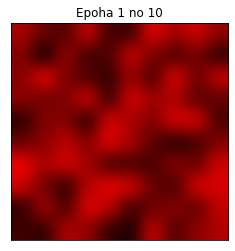

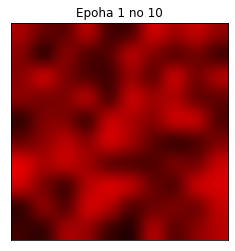

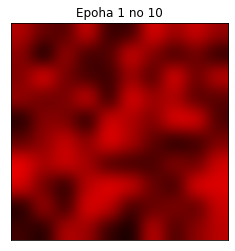

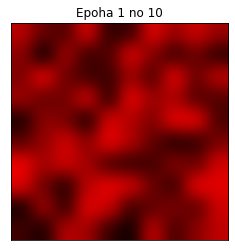

In [40]:
som_animation(list_x, 30)